# Fake News Detection

Fake News Detection is a natural language processing task that involves identifying and classifying news articles or other types of text as real or fake.

In this notebook, we will build a fake news classifier using Kaggle Fake News dataset.

**Dataset:** https://www.kaggle.com/competitions/fake-news/data?select=train.csv

The train data contains 5 columns:
- **id**: unique id for a news article
- **title**: the title of a news article
- **author**: author of the news article
- **text**: the text of the article
- **label**: a label that marks the article as potentially unreliable
(1: fake, 0: real)

## Importing Libraries

In [1]:
!pip install nltk

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


The dataset contains 20800 rows and 5 dimensions

In [5]:
df.shape

(20800, 5)

We have missing values on the title, author, and text columns. We will drop those null values

In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
df.dropna(inplace = True)

In [8]:
df.shape

(18285, 5)

## Cheking Imbalance

In [9]:
def create_distribution(feature):
    return sns.countplot(df[feature])

To visualize the distribution of the label values we need to check the data types of it. As seen below, it is encoded as integer but we will turn it into string

In [10]:
df.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

In [11]:
df['label'] = df['label'].astype(str)

In [12]:
df.dtypes

id         int64
title     object
author    object
text      object
label     object
dtype: object

<AxesSubplot:xlabel='label', ylabel='count'>

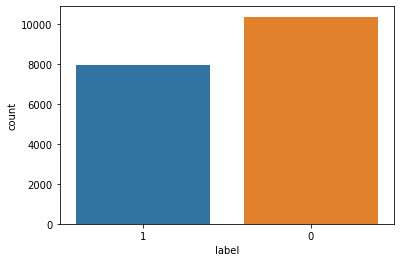

In [13]:
create_distribution('label')

We can see the deleted rows are no longer in the dataframe, for example id 6 is missing. 

In [14]:
df.head(20)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


We will create a copy of that dataframe and reset the index value.

In [15]:
news = df.copy()

In [16]:
news.reset_index(inplace = True)

In [17]:
news.head(10)

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [18]:
news.drop(['index', 'id'], axis=1, inplace=True)

In [19]:
news.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


For natural language processing, we need to remove special characters.

In [20]:
data = news['title'][0]
data

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

The below code removes everything except than a-z and A-Z remove with regex

In [21]:
re.sub('[^a-zA-Z]', ' ', data)

'House Dem Aide  We Didn t Even See Comey s Letter Until Jason Chaffetz Tweeted It'

We need to apply lower case operation

In [22]:
data = data.lower()
data

'house dem aide: we didn’t even see comey’s letter until jason chaffetz tweeted it'

And split the sentence by space

In [23]:
list = data.split()
list

['house',
 'dem',
 'aide:',
 'we',
 'didn’t',
 'even',
 'see',
 'comey’s',
 'letter',
 'until',
 'jason',
 'chaffetz',
 'tweeted',
 'it']

## Applying NLP Techniques

### Stemming

**Stemming** is a technique used to reduce an inflected word down to its word stem. 

For example, the words “programming,” “programmer,” and “programs” can all be reduced down to the common word stem “program.”

Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

In [24]:
ps = PorterStemmer()

We will remove the **stopwords** from our word list which are the English words that does not add much meaning to a sentence. 

They can safely be ignored without sacrificing the meaning of the sentence. 

For example, the words like the, he, have etc.

In [25]:
review = []
for word in list:
    if word not in set(stopwords.words('english')):
        review.append(ps.stem(word))
review

['hous',
 'dem',
 'aide:',
 'didn’t',
 'even',
 'see',
 'comey’',
 'letter',
 'jason',
 'chaffetz',
 'tweet']

In [26]:
' ' .join(review)

'hous dem aide: didn’t even see comey’ letter jason chaffetz tweet'

As we will apply those operations on each row, we should put them together and apply them to all the values of the title column.

In [27]:
corpus = []
sentences = []
for i in range(0, len(news)):
    review = re.sub('[^a-zA-Z]', ' ', news['title'][i])
    review = review.lower()
    list = review.split()
    review = [ps.stem(word) for word in list if word not in set(stopwords.words('english'))]
    sentences = ' '.join(review)
    corpus.append(sentences)

In [28]:
corpus[0]

'hous dem aid even see comey letter jason chaffetz tweet'

In [29]:
corpus

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag',
 'russian research discov secret nazi militari base treasur hunter arctic photo',
 'us offici see link trump russia',
 'ye paid govern troll social media blog forum websit',
 'major leagu soccer argentin find home success new york time',
 'well fargo chief abruptli step new york time',
 'anonym donor pay million releas everyon arrest dakota access pipelin',
 'fbi close hilla

In [30]:
len(corpus)

18285

### Bag of words 

**Bag of words (BoW)** is a statistical language model used to analyze text and documents based on word count.

It is a representation that turns arbitrary text into fixed-length vectors by counting how many times each word appears. This process is often referred to as vectorization.

In [31]:
cv = CountVectorizer(max_features = 5000, ngram_range = (1,3))

In [32]:
X = cv.fit_transform(corpus).toarray()

In [33]:
X.shape

(18285, 5000)

In [34]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We can see all the words down below

In [35]:
cv.get_feature_names()

['abandon',
 'abc',
 'abc news',
 'abduct',
 'abe',
 'abedin',
 'abl',
 'abort',
 'abroad',
 'absolut',
 'abstain',
 'absurd',
 'abus',
 'abus new',
 'abus new york',
 'academi',
 'accept',
 'access',
 'access pipelin',
 'access pipelin protest',
 'accid',
 'accident',
 'accord',
 'account',
 'accus',
 'accus trump',
 'achiev',
 'acknowledg',
 'acknowledg emf',
 'acknowledg emf damag',
 'aclu',
 'acquit',
 'acquitt',
 'acr',
 'across',
 'act',
 'act like',
 'act new',
 'act new york',
 'action',
 'activ',
 'activist',
 'actor',
 'actual',
 'ad',
 'adam',
 'add',
 'addict',
 'address',
 'adhd',
 'admin',
 'administr',
 'admir',
 'admit',
 'adopt',
 'adult',
 'advanc',
 'advertis',
 'advic',
 'advis',
 'advis new',
 'advis new york',
 'advisor',
 'advoc',
 'affair',
 'affect',
 'affili',
 'affirm',
 'afford',
 'afghan',
 'afghanistan',
 'africa',
 'african',
 'african american',
 'ag',
 'age',
 'age new',
 'age new york',
 'agenc',
 'agenda',
 'agenda breitbart',
 'agent',
 'aggress',
 '

We will get top 20 features

In [36]:
cv.get_feature_names()[0:20]

['abandon',
 'abc',
 'abc news',
 'abduct',
 'abe',
 'abedin',
 'abl',
 'abort',
 'abroad',
 'absolut',
 'abstain',
 'absurd',
 'abus',
 'abus new',
 'abus new york',
 'academi',
 'accept',
 'access',
 'access pipelin',
 'access pipelin protest']

In [37]:
news.columns

Index(['title', 'author', 'text', 'label'], dtype='object')

## Creating Model

### Train Test Split

We will use 75% of the data for training our model, and the rest for testing.

In [38]:
y = news['label']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [40]:
X_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
X_train.shape

(13713, 5000)

In [42]:
X_test.shape

(4572, 5000)

In [43]:
y_train.shape

(13713,)

In [44]:
y_test.shape

(4572,)

### Model Training

For classifying we will use the **Multinomial Naive Bayes** algorithm.

It is a Bayesian learning approach popular in Natural Language Processing (NLP). The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance.

Build the model

In [45]:
classifier = MultinomialNB()

Train the classifier with training data

In [46]:
classifier.fit(X_train, y_train)

MultinomialNB()

Get the predicted values of the classifier for testing data

In [47]:
pred = classifier.predict(X_test)
pred

array(['1', '0', '0', ..., '0', '0', '0'], dtype='<U1')

### Accuracy

If we look at the accuracy of our model, which is defined as the number of classifications a model correctly predicts divided by the total number of predictions made, it is 89%.

In [48]:
metrics.accuracy_score(y_test, pred)

0.8904199475065617

### Confusion Matrix

We can use a confusion matrix to visualize and summarize the performance of our classification algorithm.

In [49]:
cm = metrics.confusion_matrix(y_test, pred)
cm

array([[2301,  299],
       [ 202, 1770]])

In [50]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

With the confusion matrix, we can see how many of the values were predicted correctly and how many of them were labeled wrong.

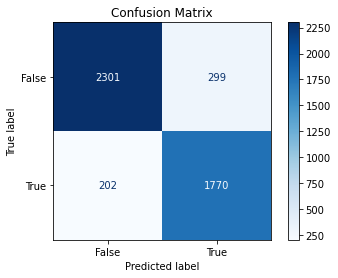

In [51]:
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Applying A Different Classifier

### Passive Aggressive Classifier

**Passive Aggressive Classifier** belongs to the category of online learning algorithms in machine learning. It works by responding as passive for correct classifications and responding as aggressive for any miscalculation.

In [52]:
linear_clf = PassiveAggressiveClassifier()

In [53]:
linear_clf.fit(X_train, y_train)

PassiveAggressiveClassifier()

In [54]:
prediction = linear_clf.predict(X_test)

### Accuracy

In [55]:
metrics.accuracy_score(y_test, prediction)

0.9101049868766404

### Confusion Matrix

In [56]:
cm2 = metrics.confusion_matrix(y_test, prediction)
cm2

array([[2359,  241],
       [ 170, 1802]])

In [57]:
cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = [False, True])

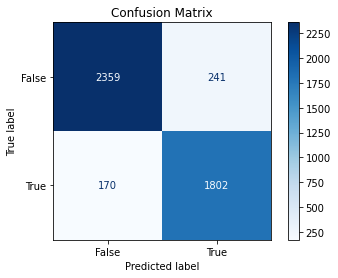

In [58]:
cm_display2.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [59]:
feature_names = cv.get_feature_names()

Most negative value is the most fake word

In [60]:
classifier.coef_[0]

array([ -8.86060051,  -8.60928608,  -9.19707274, ..., -10.80651066,
        -8.72706912,  -9.4202163 ])

Top 20 words

In [61]:
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[0:20]

[(-3.9648951809317863, 'trump'),
 (-4.272721819476034, 'hillari'),
 (-4.368759007672977, 'clinton'),
 (-4.861090048802803, 'elect'),
 (-5.219261999009128, 'new'),
 (-5.230561554263062, 'comment'),
 (-5.269176390390841, 'video'),
 (-5.355472203843678, 'war'),
 (-5.372788653855138, 'hillari clinton'),
 (-5.394864605554338, 'us'),
 (-5.412883111057016, 'fbi'),
 (-5.483500678270969, 'vote'),
 (-5.483500678270969, 'email'),
 (-5.559486585248892, 'obama'),
 (-5.570068694579429, 'world'),
 (-5.718914322176994, 'donald'),
 (-5.743915624382411, 'donald trump'),
 (-5.8229040357010415, 'russia'),
 (-5.864868234800074, 'presid'),
 (-5.872036724278686, 'america')]